# Numerical solution of uSEIR

- This notebook illustrates the numerical solutions of uSEIR equations
- A benchmark version in python is compared with a full version in cython.
- A factor 100 in speed is found.
- JJGC, May, year of the plague. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())
import numpy as np
import pandas as pd
import matplotlib

Last updated on  Sat May 16 18:43:00 2020


In [2]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [3]:
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy.stats import expon
from scipy.stats import poisson

# Exponential distribution

In [4]:
t, tvar  = expon.stats(scale=5, moments='mv')
print(t, tvar)

5.0 25.0


In [5]:
r = expon.rvs(scale=5, size=1000)

In [6]:
x = np.linspace(0,30,200)

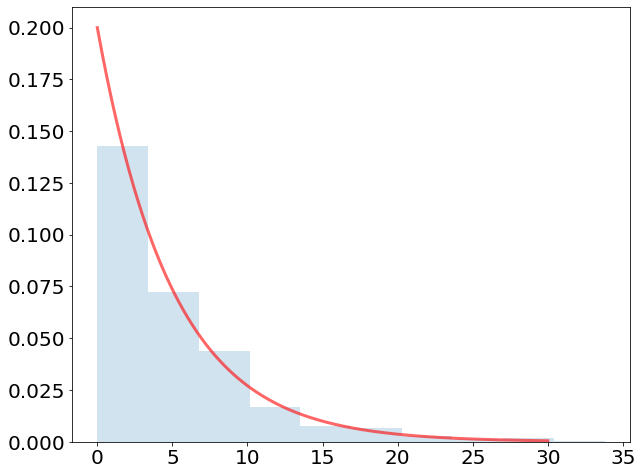

In [7]:
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.plot(x, expon.pdf(x, scale=5), 'r-', lw=3, alpha=0.6, label='expon pdf')

# Gamma distribution

In [8]:
ti, ti_var  = gamma.stats(a=3.5, scale=1, moments='mv')
print(ti, ti_var)

3.5 3.5


In [9]:
X=np.arange(0,20,0.05)
Y = gamma.pdf(X,a=3.5, scale=1)

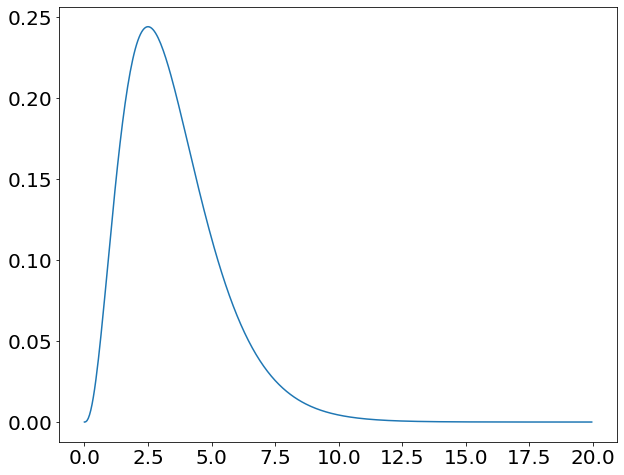

In [10]:
plt.plot(X,Y)

In [11]:
T = np.linspace(gamma.ppf(0.001, a=5.5, scale=1), gamma.ppf(0.999, a=5.5, scale=1), 500)

In [12]:
tIpdi = [gamma.pdf(t, a=5.5, scale=1) for t in T]

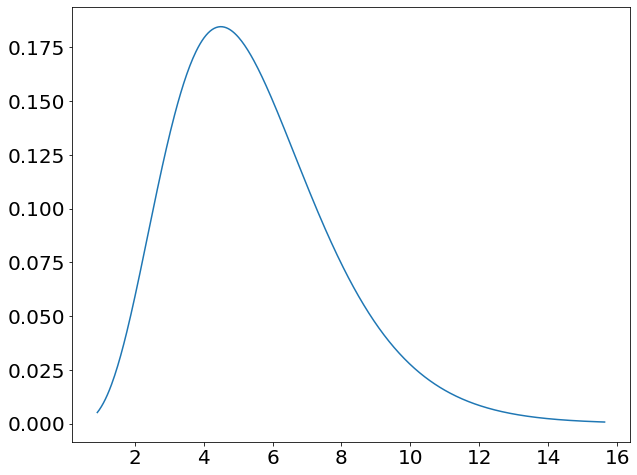

In [13]:
plt.plot(T, tIpdi)

## Poisson

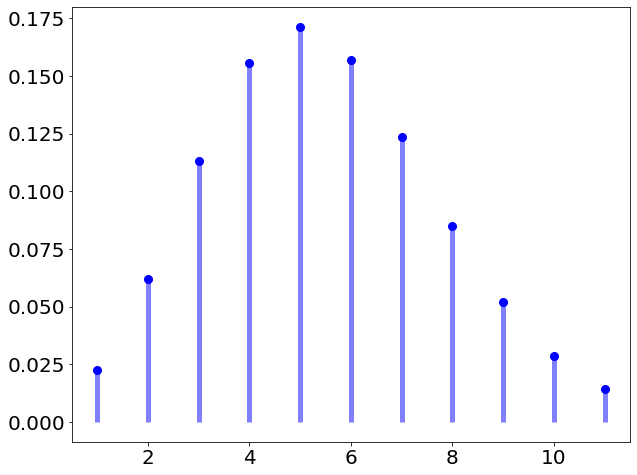

In [14]:
mu = 5.5
x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
plt.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
plt.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

# uSEIR

In [19]:
def plot_useir(dfs, lbls, T = 'uSEIR', figsize=(10,10)):
    
    fig = plt.figure(figsize=figsize)
    
    ax=plt.subplot(1,2,1)
    for i, df in enumerate(dfs):
        df.head()
        ls = f'S-{lbls[i]}'
        lr = f'R-{lbls[i]}'
        plt.plot(df.t, df.S, lw=2, label=ls)
        plt.plot(df.t, df.R, lw=2, label=lr)


    plt.xlabel('time (days)')
    plt.ylabel('Fraction of population')
    plt.legend()
    plt.title(T)
    
    ax=plt.subplot(1,2,2)
    for i, df in enumerate(dfs):
        le = f'E-{lbls[i]}'
        li = f'I-{lbls[i]}'
        plt.plot(df.t, df.E, lw=2, label=le)
        plt.plot(df.t, df.I, lw=2, label=li)

    plt.xlabel('time (days)')
    plt.ylabel('Fraction of population')
    plt.legend()
    
    plt.title(T)
    plt.tight_layout()
    plt.show()

## Pure python version

In [15]:
def solve_uSeir(ti_shape     = 5.5,  
                   ti_scale     = 1, 
                   tr_shape     = 6.5,  
                   tr_scale     = 1,
                   R0           = 3.5):
    """
    The pure python version only uses the gamma distribution and fine grain.
    It's sole purpose is benchmarking the cython version
    """
    
    def compute_gamma_pde(t_shape, t_scale, eps, tol):
        ne = int(gamma.ppf(tol, a=t_shape, scale=t_scale) / eps)
        pdE = np.zeros(ne)
        cd1 = 0
        for i in np.arange(ne):
            cd2    = gamma.cdf(i*eps, a=t_shape, scale=t_scale)
            pdE[i] = cd2-cd1
            cd1    = cd2

        return ne, pdE

    N       = 1e+6
    Smin    = 1e-10 
    Emin    = 1e-10
    nmax    = 75000
    eps     = 0.01
    prob    = R0 / tr_shape 
    pn      = prob * eps
    tol     = 0.9999

    nE, pdE = compute_gamma_pde(ti_shape, ti_scale, eps, tol)
    nI, pdI = compute_gamma_pde(tr_shape, tr_scale, eps, tol)

    print(f' Function solve_uSeir: time epsilon = {eps}')
    print(f' statistical distribution is Gamma , ti = {ti_shape}, tr = {tr_shape}')
    print(f' number of exposed compartments = {nE}, infected compartments = {nI}')
    print(f' R0 = {R0}, prob = {prob}, pn = {pn}')
     
    I   = np.zeros(nI)
    E   = np.zeros(nE)
    S    = 1 - 1/N
    E[0] = 1 / N
    
    R    = 0
    sI   = 0

    TT = []
    SS = []
    EE = []
    II = []
    RR = []
    n    = 0
    
    while True:
        
        R += I[0]
        end = nI - 1
        for k in np.arange(end):
            I[k] = I[k+1] + pdI[k] * E[0]
        I[end] = pdI[end] * E[0]
        
        #print(I)

        end = nE - 1
        for k in np.arange(end):
            E[k] = E[k+1] + pn * pdE[k] * sI * S
        E[end]   = pn * pdE[end] * sI * S

        #print(E)
        
        S  = S - pn * sI * S
        
        sI = np.sum(I)
        sE = np.sum(E)
        
        #print(sI)
        #print(sE)
        TT.append(n * eps)
        SS.append(S)
        EE.append(sE)
        II.append(sI)
        RR.append(R)
        
        #print(f't = {n*eps} S = {S} E ={sE} I ={sI} R = {R}')
        n+=1
        if (sE < Smin and sI < Emin) or n > nmax:
            break
    
    df = pd.DataFrame(list(zip(TT, SS, EE, II, RR)), 
               columns =['t', 'S', 'E', 'I', 'R']) 
    
    return df
        
    

In [16]:
t1 = time.time()
df = solve_uSeir(ti_shape     = 5.5,  
                   ti_scale     = 1, 
                   tr_shape     = 6.5,  
                   tr_scale     = 1,
                   R0           = 3.5)
t2 = time.time()
print(f'python solve_seir call: dr = {t2-t1}')

 Function solve_uSeir: time epsilon = 0.01
 statistical distribution is Gamma , ti = 5.5, tr = 6.5
 number of exposed compartments = 1868, infected compartments = 2043
 R0 = 3.5, prob = 0.5384615384615384, pn = 0.005384615384615384
python solve_seir call: dr = 56.226893186569214


In [17]:
df.head()

,t,S,E,I,R
0,0.00,0.999999,0.000000e+00,9.998988e-07,0.000000e+00
1,0.01,0.999999,5.383521e-09,9.998988e-07,0.000000e+00
2,0.02,0.999999,1.076704e-08,9.998988e-07,5.297898e-23
3,0.03,0.999999,1.615056e-08,9.998988e-07,4.753742e-21
4,0.04,0.999999,2.153408e-08,9.998988e-07,6.574555e-20


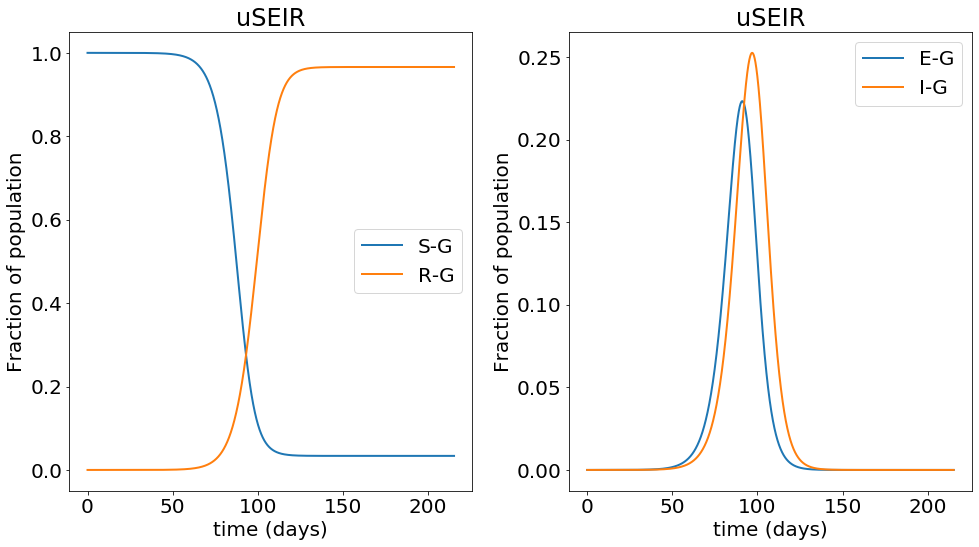

In [24]:
plot_useir((df,), ('G',), T = 'uSEIR', figsize=(14,8))

## Cython version

In [25]:
%load_ext Cython

In [26]:
%%cython 
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import poisson
import numpy as np
cimport numpy as np
import pandas as pd

cdef compute_eps(str pde_sampling ):
    if pde_sampling == 'Fine':
        eps = 0.01
        dim = 18000
    else:
        eps =  0.1 
        dim = 1800
    return eps, dim
    
cdef compute_gamma_pde(int ne, double t_shape, double t_scale, double eps):
    
    cdef double [:] pdE = np.zeros(ne, dtype=np.double) 
    cdef double cd1 = 0
    cdef double cd2
    cdef int i
       
    for i in range(ne):
        cd2    = gamma.cdf(i*eps, a=t_shape, scale=t_scale)
        pdE[i] = cd2 - cd1
        cd1    = cd2

    return pdE

cdef compute_expon_pde(int ne, double t_scale, double eps):
    
    cdef double [:] pdE = np.zeros(ne, dtype=np.double) 
    cdef double cd1 = 0
    cdef double cd2
    cdef int i
       
    for i in range(ne):
        cd2    = expon.cdf(i*eps, scale=t_scale)
        pdE[i] = cd2 - cd1
        cd1    = cd2

    return pdE

cdef compute_poisson_pde(int ne, double mu, double eps):
    
    cdef double [:] pdE = np.zeros(ne, dtype=np.double) 
    cdef double cd1 = 0
    cdef double cd2
    cdef int i
       
    for i in range(ne):
        cd2    = poisson.cdf(i*eps, mu)
        pdE[i] = cd2 - cd1
        cd1    = cd2

    return pdE

cpdef compute_pde(str dist,
                  double ti_shape,  
                  double ti_scale, 
                  double tr_shape,  
                  double tr_scale,
                  str    pde_sampling = 'Fine'):
    
    kdist =['gamma', 'expon', 'poisson']
    
    cdef double eps
    cdef int    dim
    cdef int nE
    cdef int nI
    cdef double [:] pdE
    cdef double [:] pdI
    
    eps, dim         = compute_eps(pde_sampling)
    cdef double tol  = 0.9999
    
    if dist == 'gamma':
        nE = int(gamma.ppf(tol, a=ti_shape, scale=ti_scale) / eps)
        nI = int(gamma.ppf(tol, a=tr_shape, scale=tr_scale) / eps)
        pdE = compute_gamma_pde(nE, ti_shape, ti_scale, eps)
        pdI = compute_gamma_pde(nI, ti_shape, ti_scale, eps)
        ti = float(gamma.stats(ti_shape, ti_scale, moments='m'))
        tr = float(gamma.stats(tr_shape, tr_scale, moments='m'))
        
    elif dist == 'expon':
        nE = int(expon.ppf(tol, scale=ti_scale) / eps)
        nI = int(expon.ppf(tol, scale=tr_scale) / eps)
        pdE = compute_expon_pde(nE, ti_scale, eps)
        pdI = compute_expon_pde(nI, tr_scale, eps)
        ti = float(expon.stats(scale=ti_scale, moments='m'))
        tr = float(expon.stats(scale=tr_scale, moments='m'))

    elif dist == 'poisson':
        nE = int(poisson.ppf(tol, mu=ti_shape) / eps)
        nI = int(poisson.ppf(tol, mu=tr_shape) / eps)
        pdE = compute_poisson_pde(nE, ti_shape, eps)
        pdI = compute_poisson_pde(nI, tr_shape, eps)
        ti = float(poisson.stats(mu=ti_shape, moments='m'))
        tr = float(poisson.stats(mu=ti_shape, moments='m'))
    else:
        print(f' Distribution {dist} not yet implemented please use one in {kdist}')
        return 0
      
    print(f' Function compute_pde with sampling = {pde_sampling}, time epsilon = {eps}')
    print(f' statistical distribution = {dist}, ti = {ti}, tr = {tr}')
    print(f' number of exposed compartments = {nE}, infected compartments = {nI}')
    print(f'len pdE = {len(pdE)}, max(pdE) ={np.max(pdE)} len pdi = {len(pdI)} max(pdI) ={np.max(pdI)}')
    
    return nE, pdE, nI, pdI, ti, tr
    
cpdef csolve_uSeir(str dist            = 'gamma', 
                   double ti_shape     = 5.5,  
                   double ti_scale     = 1, 
                   double tr_shape     = 6.5,  
                   double tr_scale     = 1,
                   str    pde_sampling = 'Fine',
                   double R0           = 3.5):
    """
    Function csolve_uSeir solves numerically the uSEIR equations (Hernandez et al, Preprint)
    following the numerical recipe by A. Ramos ( https://gitlab.ift.uam-csic.es/alberto/useir)
    
    THE BEER-WARE LICENSE:
    P. Hernandez, C. Pena, J.J. Gomez Cadenas wrote these files. As long
    as you retain this notice you can do whatever you want with this
    stuff. If we meet some day, and you think this stuff is worth it, you
    can buy us a beer in return.
    
    Arguments:
    dist       : either gamma, expon or poisson. Other distributions can easily be added.
    shape and scale parameters:
               for gamma you need to specify both --ti_shape, ti_scale, tr_shape, tr_scale
               for expon you need to specify only ti_scale, tr_scale (which correspond to the average ti, tr)
               for poisson you need to specify only ti_shape, tr_shape (which correspond to mu for the average ti, tr)
    
    The default sampling is Fine, which takes a epsilon time of 0.01. For faster execution specify Coarse 
    """

    cdef double N       = 1e+6,
    cdef double Smin    = 1e-10, 
    cdef double Emin    = 1e-10,
    cdef double nmax    = 75000
    cdef double eps
    cdef double pn
    cdef double prob

    cdef int    dim
    cdef int nE 
    cdef int nI
    
    cdef double [:] pdE
    cdef double [:] pdI
    
    nE, pdE, nI, pdI, ti, tr = compute_pde(dist, ti_shape, ti_scale, tr_shape, tr_scale, pde_sampling)

    cdef double [:] I   = np.zeros(nI, dtype=np.double)
    cdef double [:] E   = np.zeros(nE, dtype=np.double)
    E[0] = 1 / N


    cdef double S   = 1 - 1/N
    cdef double R   = 0
    cdef double sI  = 0
    
    prob = R0 / tr 
    eps, dim = compute_eps(pde_sampling)
    pn = prob * eps
    
    print(f'prob = {prob}, pn = {pn}')
    
    cdef np.ndarray[np.float64_t, ndim=1] TT = np.zeros(dim, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] SS = np.zeros(dim, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] EE = np.zeros(dim, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] II = np.zeros(dim, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] RR = np.zeros(dim, dtype=np.double)
    
    cdef int n    = 0
    cdef int end
    cdef int k
    while True:
        
        R += I[0]
        
        end = nI - 1
        for k in range(end):
            I[k] = I[k+1] + pdI[k] * E[0]
        I[end] = pdI[end] * E[0]
        
        #print(I)

        end = nE - 1
        for k in range(end):
            E[k] = E[k+1] + pn * pdE[k] * sI * S
        E[end]   = pn * pdE[end] * sI * S

        #print(E)
        
        S  = S - pn * sI * S
        sI = np.sum(I)
        sE = np.sum(E)
        
        TT[n] = n * eps
        SS[n] = S
        EE[n] = sE
        II[n] = sI
        RR[n] = R
        
        
        #print(f't = {n*eps} S = {S} E ={sE} I ={sI} R = {R}')
        n+=1
        if (sE < Smin and sI < Emin) or n > dim -1:
            break
    
    return pd.DataFrame({'t': TT.astype(float), 'S': SS.astype(float),'E' : EE.astype(float), 'I' : II.astype(float), 'R': RR.astype(float)})
    #return TT.astype(float), SS.astype(float), EE.astype(float), II.astype(float), RR.astype(float)
    #return TT, SS, EE, II, RR


## Solve for Poisson

In [27]:
t1 = time.time()
pdf = csolve_uSeir(dist = 'poisson', 
                         ti_shape = 5.5,  
                         tr_shape = 6.5, 
                         R0 = 3.5)
t2 = time.time()
print(f'cython solve_seir call: dr = {t2-t1}')

 Function compute_pde with sampling = Fine, time epsilon = 0.01
 statistical distribution = poisson, ti = 5.5, tr = 5.5
 number of exposed compartments = 1600, infected compartments = 1800
len pdE = 1600, max(pdE) =0.17140068409793713 len pdi = 1800 max(pdI) =0.15748293896738003
prob = 0.6363636363636364, pn = 0.006363636363636364
cython solve_seir call: dr = 0.5377411842346191


In [28]:
pdf.head()

,t,S,E,I,R
0,0.00,0.999999,0.000000e+00,9.998487e-07,0.000000e+00
1,0.01,0.999999,6.361394e-09,9.983453e-07,1.503439e-09
2,0.02,0.999999,1.268722e-08,9.983713e-07,1.503439e-09
3,0.03,0.999999,1.901325e-08,9.983972e-07,1.503478e-09
4,0.04,0.999999,2.533944e-08,9.984231e-07,1.503517e-09


## Solve for Gamma

In [29]:
t1 = time.time()
gdf = csolve_uSeir(dist = 'gamma', 
                              ti_shape = 5.5,
                              ti_scale = 1,
                              tr_shape = 6.5, 
                              tr_scale = 1,
                              R0 = 3.5)
t2 = time.time()
print(f'cython solve_seir call: dr = {t2-t1}')

 Function compute_pde with sampling = Fine, time epsilon = 0.01
 statistical distribution = gamma, ti = 6.5, tr = 7.5
 number of exposed compartments = 1868, infected compartments = 2043
len pdE = 1868, max(pdE) =0.0018461745940739904 len pdi = 2043 max(pdI) =0.0018461745940739904
prob = 0.4666666666666667, pn = 0.004666666666666667
cython solve_seir call: dr = 0.6267688274383545


## Solve for exponential

In [30]:
t1 = time.time()
edf = csolve_uSeir(dist = 'expon', 
                         ti_scale = 5.5,  
                         tr_scale = 6.5, 
                         pde_sampling = 'Fine',
                         R0 = 3.5)
t2 = time.time()
print(f'cython solve_seir call: dr = {t2-t1}')

 Function compute_pde with sampling = Fine, time epsilon = 0.01
 statistical distribution = expon, ti = 5.5, tr = 6.5
 number of exposed compartments = 5065, infected compartments = 5986
len pdE = 5065, max(pdE) =0.0018165299269177258 len pdi = 5986 max(pdI) =0.0015372787131637097
prob = 0.5384615384615384, pn = 0.005384615384615384
cython solve_seir call: dr = 1.1951532363891602


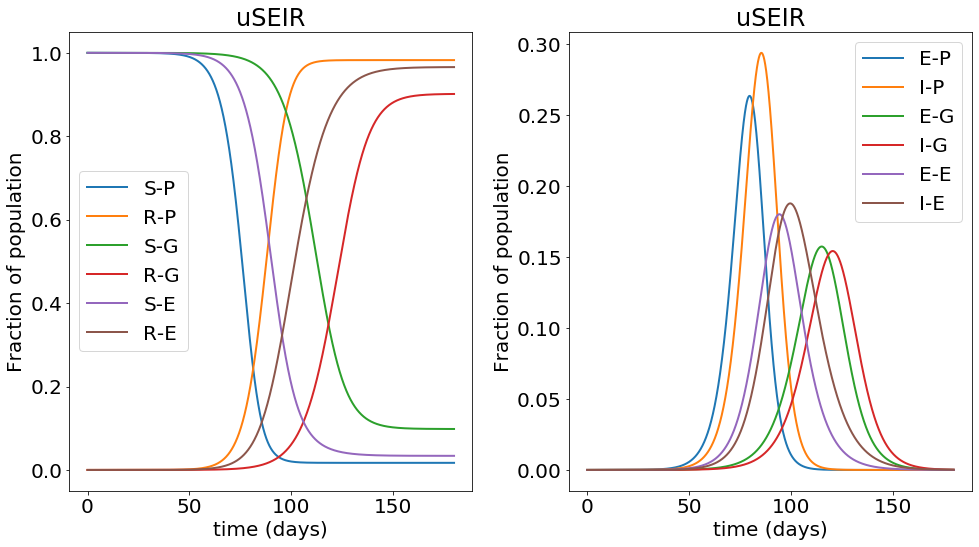

In [31]:
plot_useir((pdf,gdf,edf), ('P','G','E'), T = 'uSEIR', figsize=(14,8))